In [1]:
from fit.datamodules.super_res import MNISTSResFourierTargetDataModule
from fit.utils import convert2FC
from fit.utils.tomo_utils import get_img_coords

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
seed_everything(22122020)

22122020

In [3]:
dm = MNISTSResFourierTargetDataModule(root_dir='/data/mnist/', batch_size=32)
dm.setup()

In [4]:
model = SResTransformerModule(d_model=256, 
                             img_shape=dm.IMG_SHAPE,
                             lr=0.0001, weight_decay=0.01, n_layers=4,
                             n_heads=8, d_query=256//8, dropout=0.1, attention_dropout=0.1)

In [5]:
trainer = Trainer(max_epochs=100, 
                  gpus=1,
                  checkpoint_callback=ModelCheckpoint(
                                            filepath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Train/avg_val_loss',
                                            mode='min',
                                            prefix='best_val_loss_'
                                        ), 
                  deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [6]:
lr_finder = trainer.tuner.lr_find(model, datamodule=dm,
                            num_training=200, early_stop_threshold=4, min_lr=1e-8, max_lr=1e-2);


  | Name | Type            | Params
-----------------------------------------
0 | sres | SResTransformer | 3.2 M 
-----------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLo

/home/tbuchhol/Gitrepos/FourierImageTransformer/fit/utils/RAdam.py:119: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
LR finder stopped early due to diverging loss.


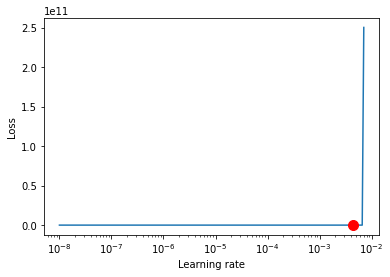

0.004365158322401657


In [7]:
fig = lr_finder.plot(show=True, suggest=True)
print(lr_finder.suggestion())

In [8]:
model.hparams.lr = 0.0001

In [9]:
trainer.fit(model, datamodule=dm);


  | Name | Type            | Params
-----------------------------------------
0 | sres | SResTransformer | 3.2 M 
-----------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params


/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [11]:
model = SResTransformerModule.load_from_checkpoint('lightning_logs/version_15/checkpoints/best_val_loss_-last.ckpt')

In [12]:
test_res = trainer.test(model, datamodule=dm)

/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Mean PSNR': array(17.624109268188477, dtype=float32),
 'SEM PSNR': array(0.02052466571331024, dtype=float32),
 'Train/avg_val_amp_loss': tensor(45.0937, device='cuda:0'),
 'Train/avg_val_loss': tensor(57.5097, device='cuda:0'),
 'Train/avg_val_phi_loss': tensor(1.6559, device='cuda:0'),
 'val_loss': tensor(57.5713, device='cuda:0')}
--------------------------------------------------------------------------------
